# Importing Important Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
from bs4 import BeautifulSoup

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# Load dataset
dataset = pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')
print(dataset['Label'].value_counts())


Label
0    7466
1    7466
Name: count, dtype: int64


#Posts Preprocessing

In [ ]:
# Applying heuristic techinques to reduce noice in the data
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    for a in soup.find_all('a'):
        a.replace_with('[external-link]')
    for img in soup.find_all('img'):
        img.replace_with('[figure]')
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    clean_text = soup.get_text()
    return clean_text

# Clean the dataset
dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

dataset['Question_body_preprocessed'] = dataset['Question_body_cleaned'].apply(preprocess_text)

In [ ]:
# Tokenize the text and train Word2Vec model
texts = dataset['Question_body_preprocessed'].astype(str).tolist()
tokenized_texts = [text.split() for text in texts]
word2vec_model = Word2Vec(tokenized_texts, vector_size=200, window=5, min_count=1, workers=4)

In [ ]:
# Create embedding matrix
vocab_size = len(word2vec_model.wv.key_to_index) + 1
embedding_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

word_index = {word: index for index, word in enumerate(word2vec_model.wv.index_to_key, 1)}
for word, index in word_index.items():
    embedding_matrix[index] = word2vec_model.wv[word]

In [ ]:
texts = dataset['Question_body_preprocessed'].astype(str).tolist()
tokenized_texts = [text.split() for text in texts]
word2vec_model = Word2Vec(tokenized_texts, vector_size=200, window=5, min_count=1, workers=4)

In [ ]:
sequences = [[word_index.get(word, 0) for word in text] for text in tokenized_texts]
max_len = 100
data = pad_sequences(sequences, maxlen=max_len)

# Split the data into training and testing sets
labels = dataset['Label'].tolist()
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define the TextCNN model

In [ ]:
# Define the TextCNN model
def create_model_Word2Vec(vocab_size, embedding_dim, max_len, embedding_matrix):
    inputs = Input(shape=(max_len,))
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(inputs)

    conv1 = Conv1D(128, 3, activation='relu')(embedding)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 4, activation='relu')(embedding)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, 5, activation='relu')(embedding)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    concatenated = concatenate([pool1, pool2, pool3], axis=1)
    flatten = Flatten()(concatenated)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the model
model = create_model_Word2Vec(vocab_size, embedding_dim, max_len, embedding_matrix)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [ ]:
print(y_train.shape, y_test.shape)

(11945,) (2987,)


In [ ]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
print(y_train.shape, y_test.shape)

(11945, 1) (2987, 1)


In [ ]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32).reshape(-1)
y_test = np.array(y_test, dtype=np.float32).reshape(-1)

In [ ]:
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_test.shape, x_test.dtype)
print(y_test.shape, y_test.dtype)

(11945, 100) float32
(11945, 1) float32
(2987, 100) float32
(2987, 1) float32


# Train the model

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 68s 176ms/step - accuracy: 0.8772 - loss: 0.3632 - val_accuracy: 0.9240 - val_loss: 0.1920
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 68s 140ms/step - accuracy: 0.9394 - loss: 0.1664 - val_accuracy: 0.9280 - val_loss: 0.1939
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 80s 136ms/step - accuracy: 0.9548 - loss: 0.1243 - val_accuracy: 0.9210 - val_loss: 0.2180
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 88s 151ms/step - accuracy: 0.9760 - loss: 0.0686 - val_accuracy: 0.9223 - val_loss: 0.2211
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 77s 139ms/step - accuracy: 0.9816 - loss: 0.0508 - val_accuracy: 0.9237 - val_loss: 0.3372
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 83s 142ms/step - accuracy: 0.9884 - loss: 0.0330 - val_accuracy: 0.9230 - val_loss: 0.4164
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 81s 139ms/step - accuracy: 0.9930 - loss: 0.0239 - val_accuracy: 0.9173 - val_loss: 0.3948
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 84s 144ms/step - accuracy: 0.9907 - loss: 0

# Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9136 - loss: 0.4952
Test Accuracy: 0.9126


In [ ]:
# Compute overall precision, recall, f1-score, and accuracy
precision, recall, f1 = precision_recall_fscore_support(y_test, y_pred, average="binary")[:3]
accuracy = accuracy_score(y_test, y_pred)

# Print overall results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 0.8829
Recall: 0.9510
F1-score: 0.9157
Accuracy: 0.9126


# Prediction results analysis with Confusion Matrix

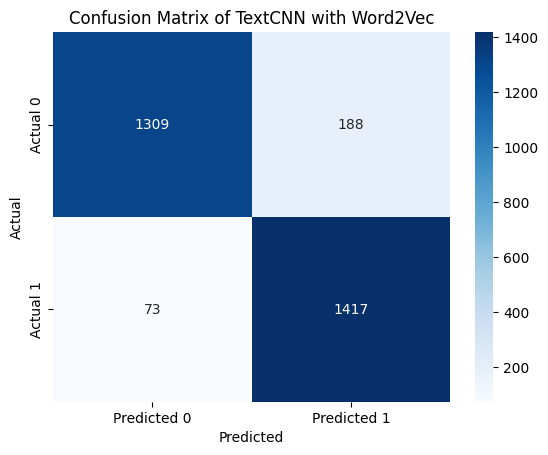

In [ ]:
# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of TextCNN with Word2Vec')
plt.show()